In [1]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from gibbsrank import gibbs_sample
from eprank import eprank
import pandas
from cw2 import sorted_barplot

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [2]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
G = data['G'] - 1
# Number of players
M = W.shape[0]
# Number of Games
N = G.shape[0]

# Gibbs sampling (This may take a minute)

In [27]:
# number of iterations
num_iters = 1100
# perform gibbs sampling, skill samples is an num_players x num_samples array
skill_samples = gibbs_sample(G, M, num_iters)#, random_nums)

100%|███████████████████████████████████████| 1100/1100 [00:34<00:00, 31.59it/s]


In [29]:
P = [0, 4, 10, 15]
for p in P:
    print('{}: mean{:.2f}; var{:.2f}'.format(p, np.mean(skill_samples[p, 100::10]), np.var(skill_samples[p, 100::10])))
    print(len(skill_samples[p, 100::10]))

0: mean1.49; var0.03
100
4: mean1.55; var0.03
100
10: mean1.31; var0.04
100
15: mean1.90; var0.05
100


(107, 1100)

## Qa

<Figure size 432x288 with 0 Axes>

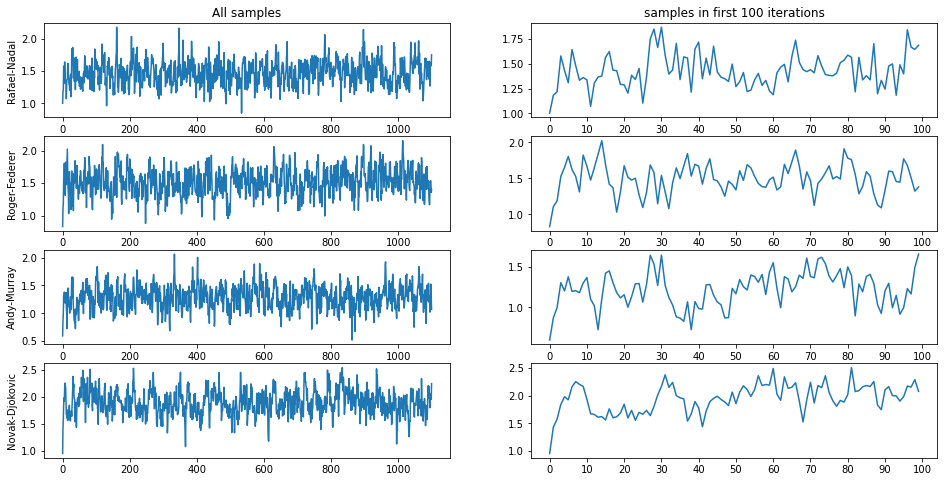

In [30]:
# Code for plotting the autocorrelation function for player p
plt.tight_layout()
P = [0, 4, 10, 15]
names = [W[i, 0] for i in P]
fig = plt.figure(figsize=(16, 8))
for j, p in enumerate(P):
#     autocor = np.zeros(11)
#     for i in range(11):
#         autocor[i]=pandas.Series.autocorr(pandas.Series(skill_samples[p,:]),lag=i)
    plt.subplot(4, 2, (j + 1) * 2)
    plt.plot(skill_samples[p, :100])
    plt.xticks(np.arange(0, 101, 10))
    if j == 0:
        plt.title('samples in first 100 iterations')
#     plt.plot(autocor)
#     plt.xticks(np.arange(11))
    plt.subplot(4, 2, j * 2 + 1)
    plt.plot(skill_samples[p, :])
    plt.ylabel(names[j])
    if j == 0:
        plt.title('All samples')
#     plt.title(names[j])
plt.savefig('plots/a1.jpg')

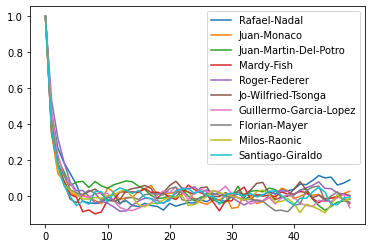

In [31]:
max_lag = 50
for p in np.arange(10):
    autocor = np.zeros(max_lag)
    for i in range(max_lag):
        autocor[i]=pandas.Series.autocorr(pandas.Series(skill_samples[p,:]),lag=i)
#     plt.subplot(4, 2, (j + 1) * 2)
    plt.plot(autocor)
plt.xticks(np.arange(0, max_lag, 10))
plt.legend(W[:10, 0])
plt.savefig('plots/a2.jpg')

In [32]:
def gibbs_convergence_plot(samples, burning_time=100, tau=10):
    subsample1 = samples[burning_time + 3::tau].flatten()[:200]
    subsample2 = samples[burning_time + 17::tau].flatten()[:200]
#     subsample3 = samples[burning_time + 17::tau].flatten()[:200]
    plt.hist(subsample1, alpha=0.7, density=True)
#     plt.plot(np.arange(len(subsample1)), subsample1)
#     plt.plot(np.arange(len(subsample2)), subsample2)
    plt.hist(subsample2, alpha=0.5, density=True)
#     plt.hist(subsample3, alpha=0.3, density=True)
#     plt.suptitle('burning time = {:.2f}, interval = {:.2f}'.format(burning_time, tau))
    plt.legend([1, 2, 3])
    plt.title('burning time = {:.2f}, interval = {:.2f}'.format(burning_time, tau))

In [33]:
# plt.tight_layout()
# P = [0, 4, 10, 15]
# names = [W[i, 0] for i in P]
# fig = plt.figure(figsize=(16, 8))
# for j, p in enumerate(P):
#     plt.subplot(2, 2, (j + 1))
#     plt.plot(skill_samples[p, :100])
#     plt.ylabel(names[j])
#     plt.title(names[j])
# plt.savefig('plots/a1.jpg')

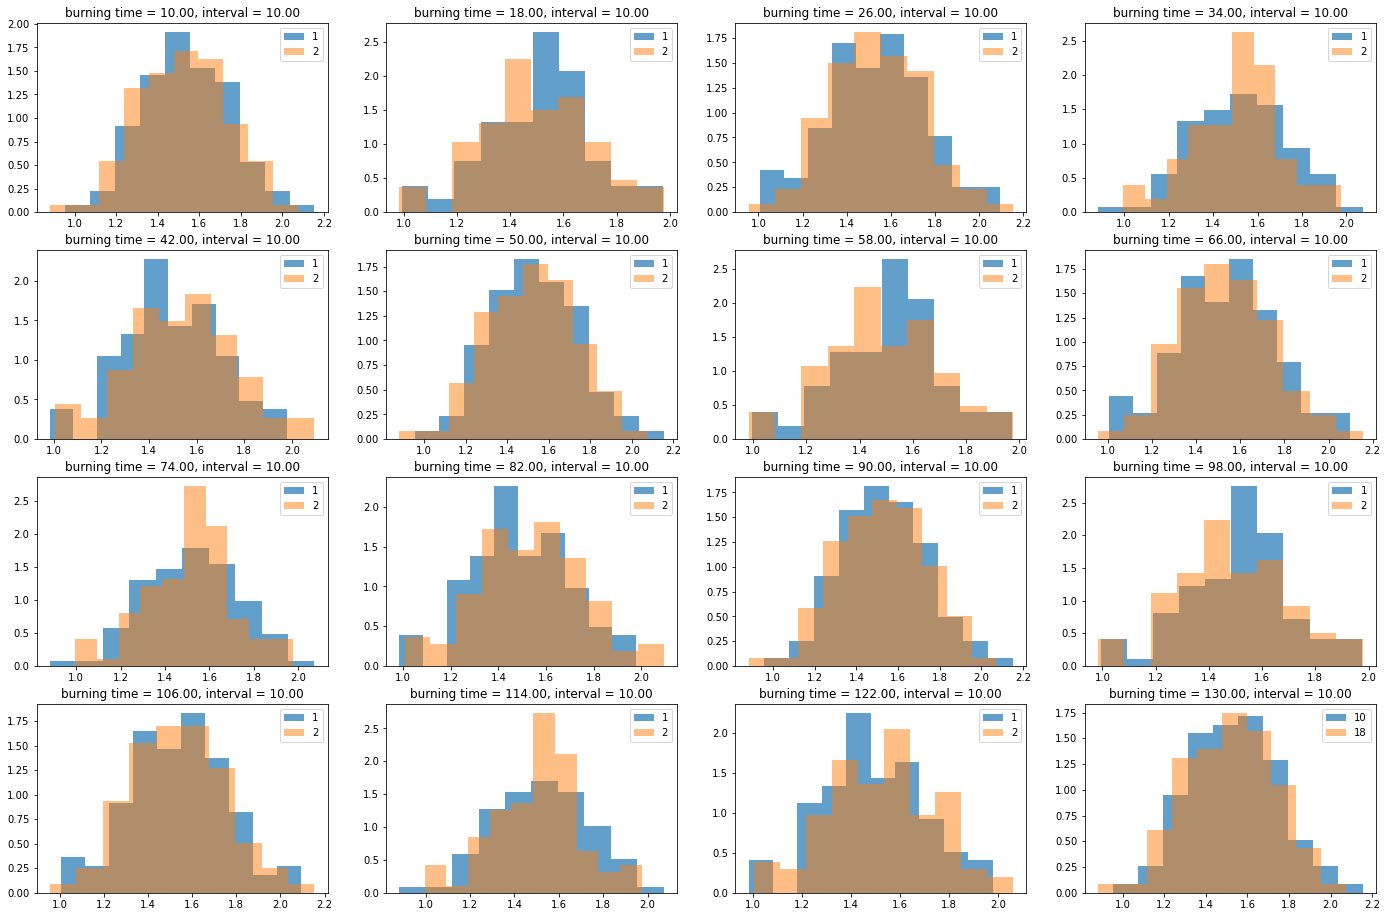

In [35]:
# burns = [25, 50, 75, 100]
# for p in P:
p = 4
burns = np.arange(10, 10 + 16 * 8, 8)
plt.figure(figsize=(24, 16))
for i, burn in enumerate(burns):
    plt.subplot(4, 4, i + 1)
    gibbs_convergence_plot(skill_samples[p], burning_time=burn)
plt.legend(burns)
plt.savefig('plots/a3.jpg')

# EP ranking
## Qb

In [48]:
num_iters = 50
# run message passing algorithm, returns mean and precision for each player
import time
t1 = time.time()
mean_player_skills, precision_player_skills = eprank(G, M, num_iters)
t2 = time.time()
t2 - t1

0.13679194450378418

In [49]:
def ep_convergence_plot(means, precisions, player_id):
    ind = np.arange(len(means))
    plt.subplot(1, 2, 1)
    plt.plot(ind, means[:, player_id])
    plt.xticks(np.arange(0, 51, 10))
    plt.xlabel('iteration')
    plt.ylabel('mean')
    plt.subplot(1, 2, 2)
    plt.plot(ind, precisions[:, player_id])
    plt.xlabel('iteration')
    plt.ylabel('precision')
    plt.xticks(np.arange(0, 51, 10))

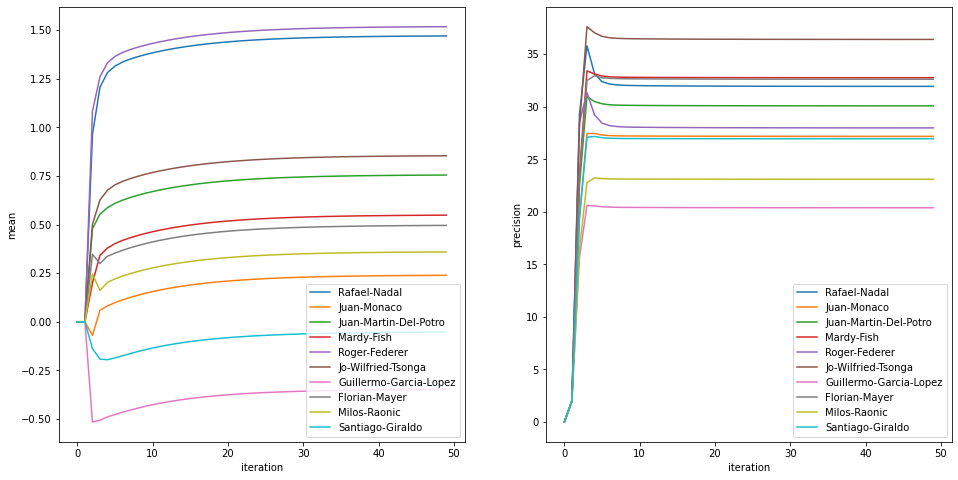

In [50]:
iters = np.arange(50)
ms = np.zeros((len(iters), M))
ps = np.zeros((len(iters), M))
for i, num_iters in enumerate(iters):
    mean_player_skills, precision_player_skills = eprank(G, M, num_iters)
    ms[i, :] = mean_player_skills
    ps[i, :] = precision_player_skills
plt.figure(figsize=(16, 8))
for p in np.arange(10):
    ep_convergence_plot(ms, ps, p)
plt.subplot(1, 2, 1)
plt.legend([W[p][0] for p in np.arange(10)], loc=4)
plt.subplot(1, 2, 2)
plt.legend([W[p][0] for p in np.arange(10)])
plt.savefig('plots/b.jpg')

## Qc

In [79]:
import scipy
def prob_diffskill(mean1, mean2, precision1, precision2):
    return scipy.stats.norm.cdf((mean1 - mean2) / np.sqrt(1 / precision1 + 1 / precision2))

def prob_winning(mean1, mean2, precision1, precision2, noise=1):
    return scipy.stats.norm.cdf((mean1 - mean2) / np.sqrt(1 / precision1 + 1 / precision2 + noise ** 2))

def plot_mat(matrix1, matrix2, labels, titles=['ProbBetter', 'ProbWin']):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    cax1 = ax1.matshow(matrix1, cmap='viridis')
    ax1.set_xticks([0, 1, 2, 3])
    ax2.set_xticks([0, 1, 2, 3])
    ax1.set_yticks([0, 1, 2, 3])
    ax2.set_yticks([0, 1, 2, 3])
    ax1.set_xticklabels(names)
    ax1.set_yticklabels(names)
    ax2.set_xticklabels(names)
    ax2.set_yticklabels(names)
    ax1.set_title(titles[0])
    ax2.set_title(titles[1])
    for i in range(matrix1.shape[0]):
        for j in range(matrix1.shape[1]):
            if i == j:
                tmp = 'NA'
            else:
                tmp = str(round(matrix1[i, j], 2))
            ax1.annotate(tmp, fontsize=20, color='red',
                        xy=(j, i),
                        horizontalalignment='center',
                        verticalalignment='center',
                        weight='bold')
    for i in range(matrix2.shape[0]):
        for j in range(matrix2.shape[1]):
            if i == j:
                tmp = 'NA'
            else:
                tmp = str(round(matrix2[i, j], 2))
            ax2.annotate(tmp, fontsize=20, color='red',
                        xy=(j, i),
                        horizontalalignment='center',
                        verticalalignment='center', 
                        weight='bold')

    cax2 = ax2.matshow(matrix2, cmap='viridis')
#     cbar = plt.colorbar(cax1, ax=[ax1, ax2], orientation='horizontal')

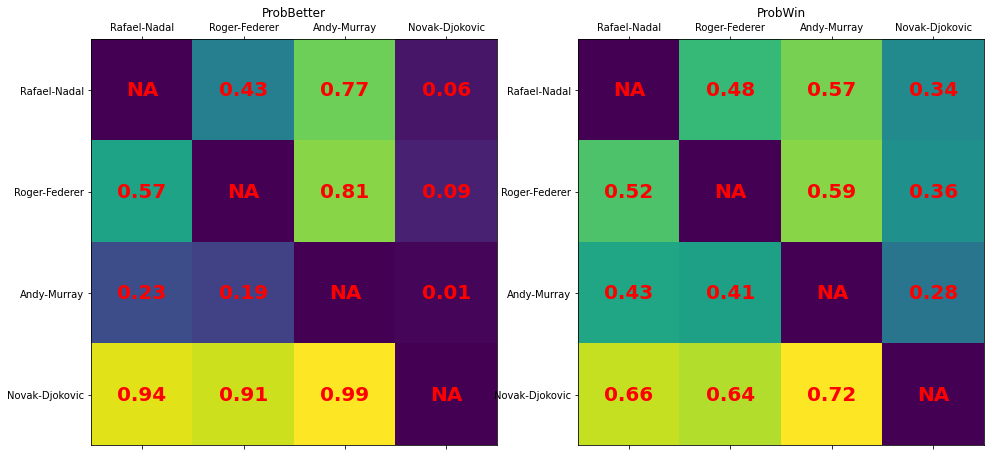

In [80]:
diffskill = np.zeros((4, 4))
winning = np.zeros((4, 4))
for i, p1 in enumerate(P):
    for j, p2 in enumerate(P):
        diffskill[i, j] = prob_diffskill(mean_player_skills[p1], mean_player_skills[p2], 
                                         precision_player_skills[p1], precision_player_skills[p2])
        winning[i, j] = prob_winning(mean_player_skills[p1], mean_player_skills[p2], 
                                         precision_player_skills[p1], precision_player_skills[p2], noise=1)
    diffskill[i, i] = 0
    winning[i, i] = 0

plot_mat(diffskill, winning, names)
plt.savefig('plots/c.jpg')

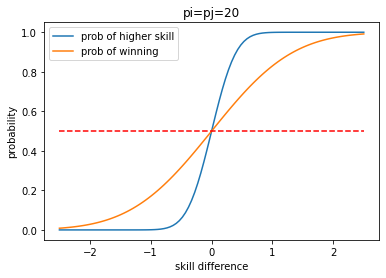

In [45]:
plt.tight_layout()
mean_diff = np.linspace(-2.5, 2.5, 100)
plt.plot(mean_diff, scipy.stats.norm.cdf(mean_diff / np.sqrt(1 / 20 + 1 / 20)))
plt.plot(mean_diff, scipy.stats.norm.cdf(mean_diff / np.sqrt(1 / 20 + 1 / 20 + 1)))
plt.plot(mean_diff, np.ones_like(mean_diff) / 2, 'r--')
plt.xlabel('skill difference')
plt.ylabel('probability')
plt.legend(['prob of higher skill', 'prob of winning'])
plt.title('pi=pj=20')
plt.savefig('plots/b2.jpg')

## Qd
### Question: Does "approximating their marginal skills by Gaussians" means using a Gaussian to approximate the sampled skills?
### 1. Approximating marginal by Gaussian

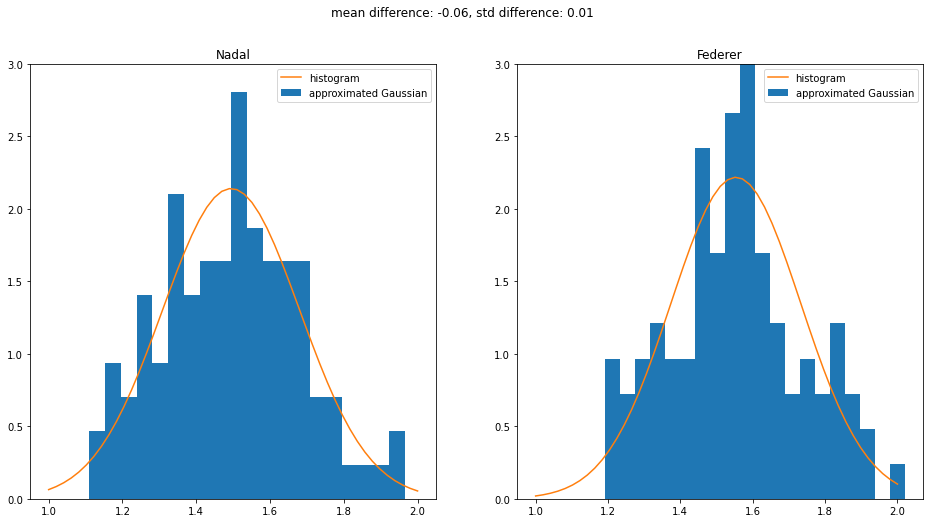

Prob Nadal better than Federer=0.47


In [54]:
# Nadal: P[0], Federer: P[1]
burning_time = 100
tau = 10
Nadal = skill_samples[P[0], burning_time::tau].flatten()
Federer = skill_samples[P[1], burning_time::tau].flatten()
Nadal_mean = np.mean(Nadal)
Nadal_std = np.std(Nadal)
Federer_mean = np.mean(Federer)
Federer_std = np.std(Federer)
x = np.linspace(1, 2, 50)
pdf_Nadal = scipy.stats.norm.pdf(x, loc=Nadal_mean, scale=Nadal_std)
pdf_Federer = scipy.stats.norm.pdf(x, loc=Federer_mean, scale=Federer_std)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
ax1.hist(Nadal, bins=20, density=True)
ax1.plot(x, pdf_Nadal)
ax2.hist(Federer, bins=20, density=True)
ax2.plot(x, pdf_Federer)
ax1.set_title('Nadal')
ax2.set_title('Federer')
ax1.set_ylim([0, 3])
ax2.set_ylim([0, 3])
ax1.legend(['histogram', 'approximated Gaussian'])
ax2.legend(['histogram', 'approximated Gaussian'])
plt.suptitle("mean difference: {:.2f}, std difference: {:.2f}".
             format(Nadal_mean - Federer_mean, Nadal_std - Federer_std))
plt.savefig('plots/d1.jpg')
plt.show()
print("Prob Nadal better than Federer={:.2f}".format(prob_diffskill(Nadal_mean, Federer_mean, Nadal_std ** (-1/2), Federer_std ** (-1/2))))

### 2. Approximating joint by Gaussian

array([[0.41277876]])

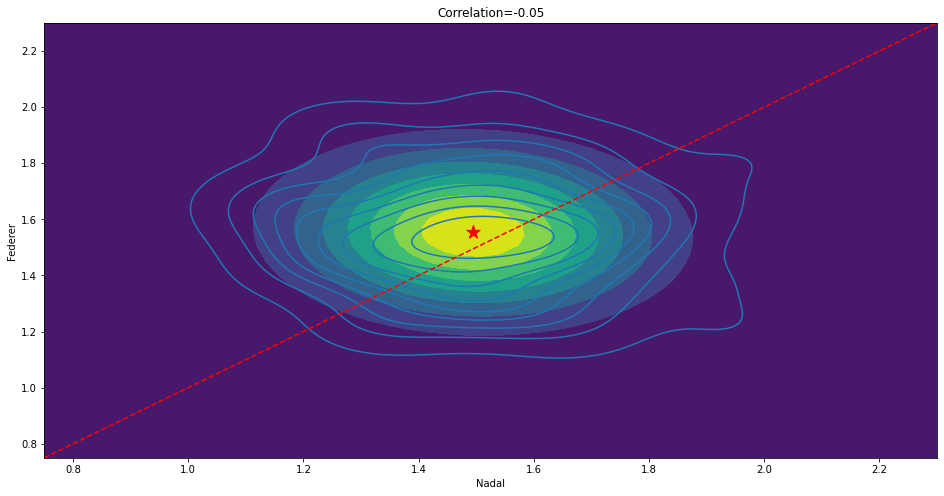

In [65]:
from scipy.stats import multivariate_normal
mu = [Nadal_mean, Federer_mean]  # Mean
cov = np.cov(np.vstack((Nadal, Federer)))
x, y = np.meshgrid(np.linspace(0.75, 2.3, 50), np.linspace(0.75, 2.3, 50))
pos = np.dstack((x, y))
rv = multivariate_normal(mu, cov)
plt.figure(figsize=(16, 8))
sns.kdeplot(x=Nadal, y=Federer, )
plt.contourf(x, y, rv.pdf(pos))
plt.xlabel('Nadal')
plt.ylabel('Federer')
plt.scatter(mu[0], mu[1], s=200, marker='*', c='red')
plt.plot(np.linspace(0.75, 2.3, 50), np.linspace(0.75, 2.3, 50), 'r--')
corr = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
plt.title('Correlation={:.2f}'.format(corr))
# plt.legend(['Joint distribution', 'Approximated Gaussian'])
plt.savefig('plots/d2.jpg')

a = np.array([[1], [-1]])
scipy.stats.norm.cdf((mu[0] - mu[1]) / np.sqrt(a.T @ cov @ a))

<AxesSubplot:>

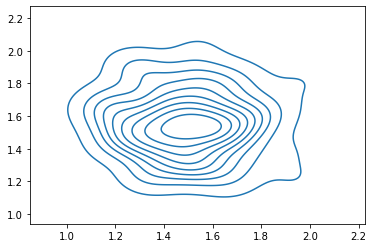

In [58]:
sns.kdeplot(x=Nadal, y=Federer, )

### 3. Compare with samples

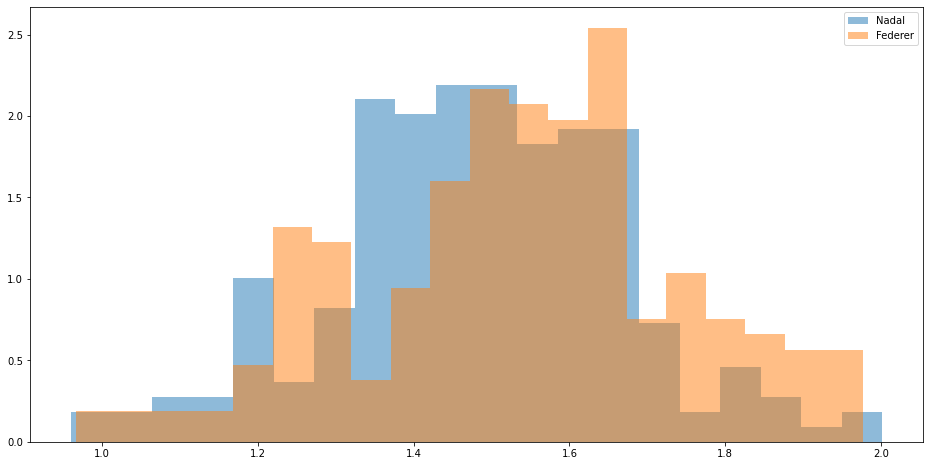

In [16]:
plt.figure(figsize=(16, 8))
pdf1 = plt.hist(Nadal, bins=20, density=True, alpha=0.5)
pdf2 = plt.hist(Federer, bins=20, density=True, alpha=0.5)
# plt.plot(pdf1[0], pdf1[1])
# plt.plot(pdf2[0], pdf2[1])
plt.legend(['Nadal', 'Federer'])
plt.savefig('plots/d3.jpg')
plt.show()

By Monte Carlo, $p(w_1>w_2)=\frac{\#\{w_1^{n}>w_2^{n}: n=1,...,N\}}{N}$. And it's the best, since: 1. Monte Carlo is guaranteed to converge when number of samples go large; 2. Gaussian might not be a good approximation since neither posterior $p(w|y)$, $p(t|y)$ and $p(w, t|y)$ are Gaussians.

In [17]:
prob_Nadal_better = np.mean(Nadal > Federer)
print("prob_Nadal_better = {}".format(prob_Nadal_better))

prob_Nadal_better = 0.3904761904761905


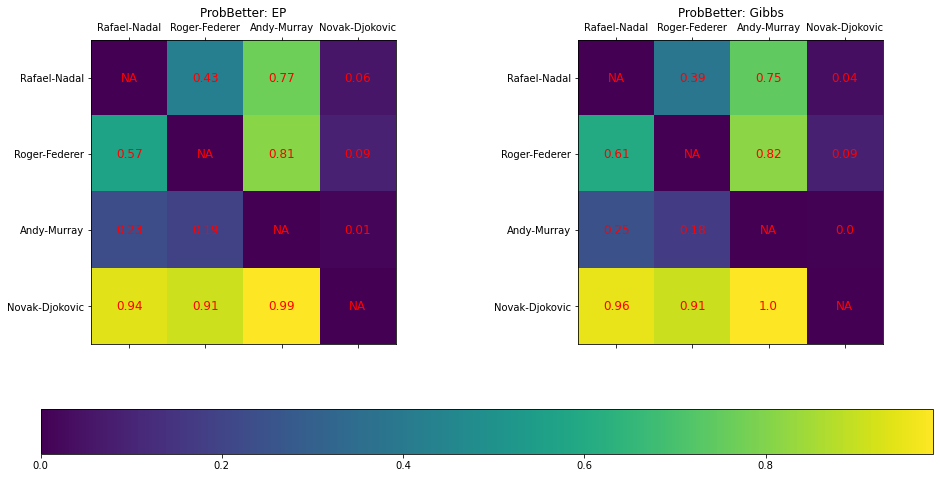

In [18]:
mat = np.zeros((4, 4))
for i, p1 in enumerate(P):
    for j, p2 in enumerate(P):
        mat[i, j] = np.mean(skill_samples[p1, burning_time::tau] > skill_samples[p2, burning_time::tau])
plot_mat(diffskill, mat, names, titles=['ProbBetter: EP', 'ProbBetter: Gibbs'])
plt.savefig('plots/d4.jpg')

### 4. Mean and std for each player

In [19]:
gibbs_skill_mean = np.zeros(4)
ep_skill_mean = np.zeros(4)
gibbs_skill_std = np.zeros(4)
ep_skill_std = np.zeros(4)
for i, p in enumerate(P):
    gibbs_skill_mean[i] = np.mean(skill_samples[p, burning_time::tau])
    gibbs_skill_std[i] = np.std(skill_samples[p, burning_time::tau])
    ep_skill_mean[i] = mean_player_skills[p]
    ep_skill_std[i] = precision_player_skills[p] ** (- 1 / 2)
    print(names[i] + ' - Gibbs: {:.2f}+-{:.2f}'.format(gibbs_skill_mean[i], gibbs_skill_std[i]))
    print(names[i] + ' - EP: {:.2f}+-{:.2f}'.format(ep_skill_mean[i], ep_skill_std[i]))

Rafael-Nadal - Gibbs: 1.48+-0.19
Rafael-Nadal - EP: 1.47+-0.18
Roger-Federer - Gibbs: 1.54+-0.21
Roger-Federer - EP: 1.52+-0.19
Andy-Murray - Gibbs: 1.29+-0.22
Andy-Murray - EP: 1.28+-0.19
Novak-Djokovic - Gibbs: 1.92+-0.22
Novak-Djokovic - EP: 1.88+-0.20


## Qe

### 1. Empirical Outcomes

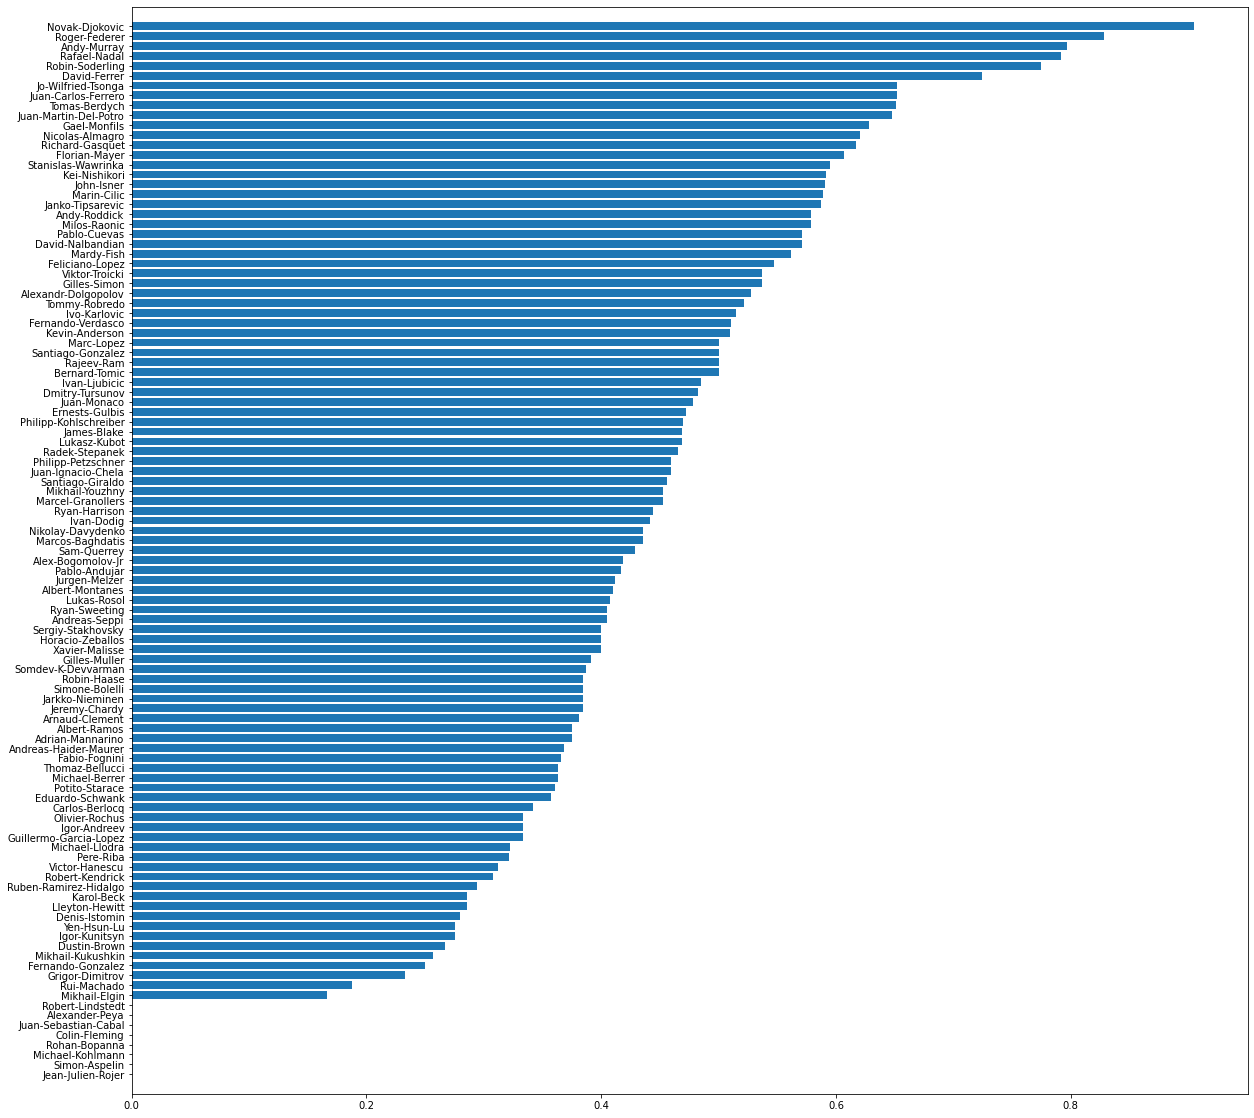

In [75]:
import pandas as pd
data = pd.DataFrame(G)
empirical_score = np.zeros(len(W))
game_count = np.zeros(len(W))

win_count = data.groupby(0).count()
empirical_score[win_count.index] += win_count.values.flatten()
game_count[win_count.index] += win_count.values.flatten()

loss_count = data.groupby(1).count()
# empirical_score[loss_count.index] -= loss_count.values.flatten()
game_count[loss_count.index] += loss_count.values.flatten()

empirical_score /= game_count

sorted_barplot(empirical_score, W)
plt.savefig('plots/e1.jpg')

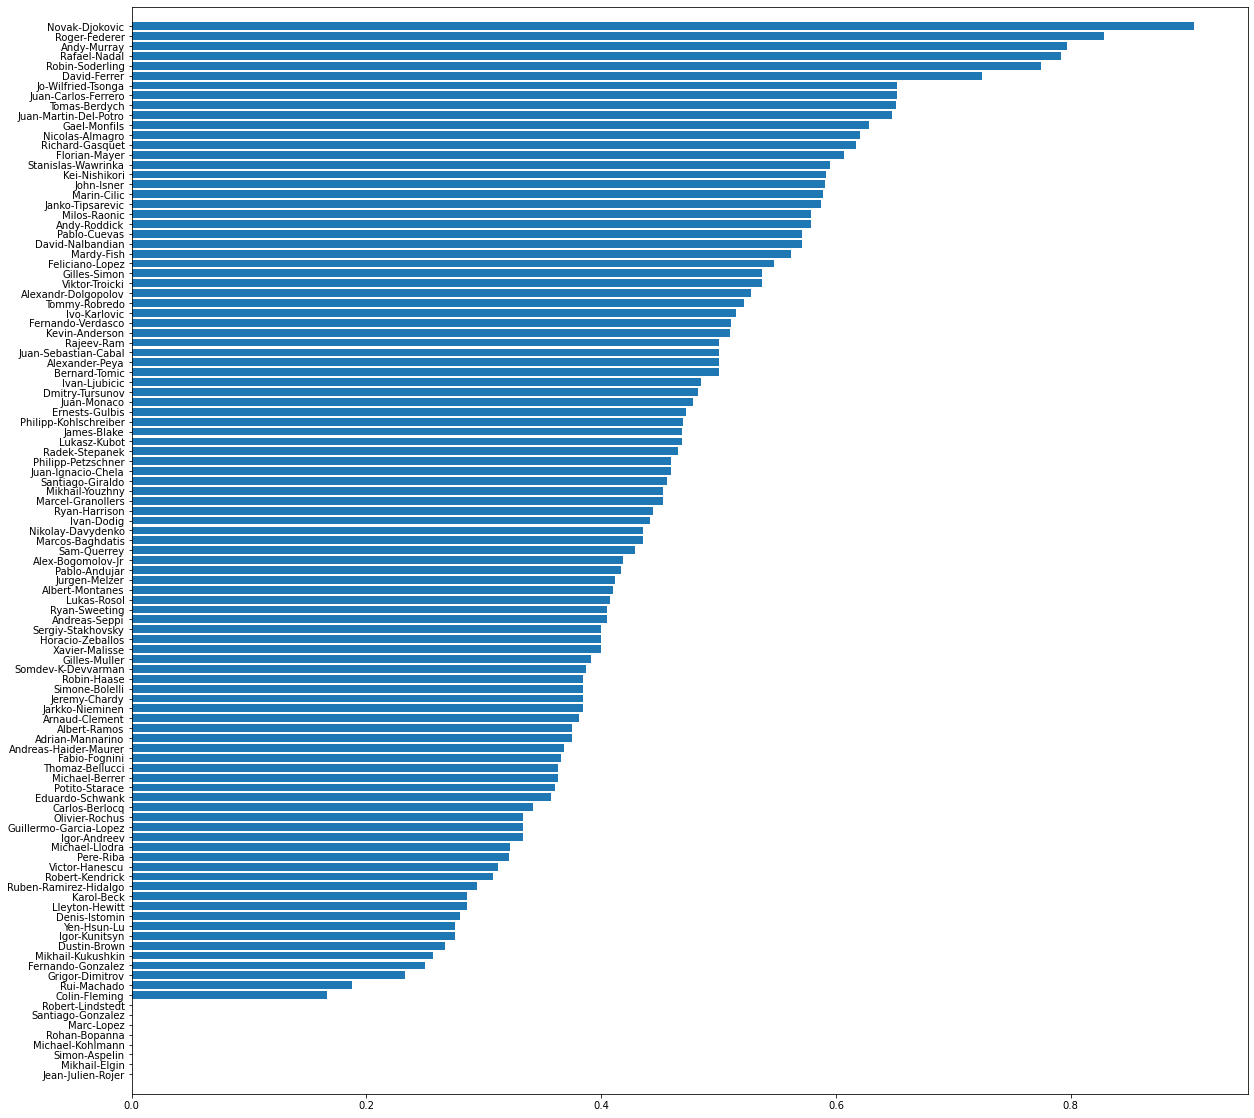

In [114]:
data = pd.DataFrame(G)
d1 = data.groupby(0).count()
d2 = data.groupby(1).count()
d = pd.concat([d1, d2], axis=1).fillna(0).apply(lambda x: x[1] / (x[0] + x[1]), axis=1).values.flatten()
sorted_barplot(d, W)

In [48]:
worsest_players = np.argsort(empirical_score)[:8]
game_played = np.zeros_like(worsest_players)
for i, p in enumerate(worsest_players):
    game_played[i] = len(np.where(G[:, 1] == p)[0])
resort_worest = worsest_players[np.argsort(game_played)[::-1]]
game_played[np.argsort(game_played)[::-1]]
print(W[resort_worest])

[['Rohan-Bopanna']
 ['Alexander-Peya']
 ['Juan-Sebastian-Cabal']
 ['Robert-Lindstedt']
 ['Colin-Fleming']
 ['Michael-Kohlmann']
 ['Simon-Aspelin']
 ['Jean-Julien-Rojer']]


In [76]:
empirical_score[29]

0.7246376811594203

In [27]:
i = np.arange(M)[np.where(W.flatten() == 'Rohan-Bopanna')]
print(W[G[np.where(G[:, 1] == i), 0].flatten()])

j = np.arange(M)[np.where(W.flatten() == 'Rui-Machado')]
print('lose', len(W[G[np.where(G[:, 1] == j), 0].flatten()]), 'win', W[G[np.where(G[:, 0] == j), 1].flatten()])



[['Kei-Nishikori']
 ['Bernard-Tomic']
 ['Stanislas-Wawrinka']
 ['Viktor-Troicki']]
lose 13 win [['Olivier-Rochus']
 ['Horacio-Zeballos']
 ['Albert-Montanes']]


array([['Rafael-Nadal'],
       ['Juan-Monaco'],
       ['Juan-Martin-Del-Potro'],
       ['Mardy-Fish'],
       ['Roger-Federer'],
       ['Jo-Wilfried-Tsonga'],
       ['Guillermo-Garcia-Lopez'],
       ['Florian-Mayer'],
       ['Milos-Raonic'],
       ['Santiago-Giraldo'],
       ['Andy-Murray'],
       ['Richard-Gasquet'],
       ['David-Nalbandian'],
       ['Gilles-Muller'],
       ['Andy-Roddick'],
       ['Novak-Djokovic'],
       ['Fernando-Verdasco'],
       ['Ivan-Dodig'],
       ['Ryan-Sweeting'],
       ['Radek-Stepanek'],
       ['John-Isner'],
       ['Pablo-Andujar'],
       ['Ivan-Ljubicic'],
       ['Robin-Soderling'],
       ['Feliciano-Lopez'],
       ['Marin-Cilic'],
       ['Marcos-Baghdatis'],
       ['Michael-Llodra'],
       ['Gael-Monfils'],
       ['David-Ferrer'],
       ['Jarkko-Nieminen'],
       ['Kei-Nishikori'],
       ['Alexandr-Dolgopolov'],
       ['Tomas-Berdych'],
       ['Somdev-K-Devvarman'],
       ['Ivo-Karlovic'],
       ['Olivier-Rochus'],
 

## The previous worest player should be the worest player in Gibbs and EP as well. But weirdly, it's not the case. For example, Bopanna played 4 games and lost all, but is ranked 101 in both Gibbs and EP!!!

### 2. Gibbs sampling
### I use the sample means as the measurement of skills

### Gibbs sampling - 2.0
### use Monte Carlo to estimate p(player i is better than others) for each i, and use this probability as a score
### TODO: Notice that now Gibbs sampling assigns non-zero scores for the worest players, check whether it makes sense, i.e. is the last player is the player who didn't win any game but played most of games.

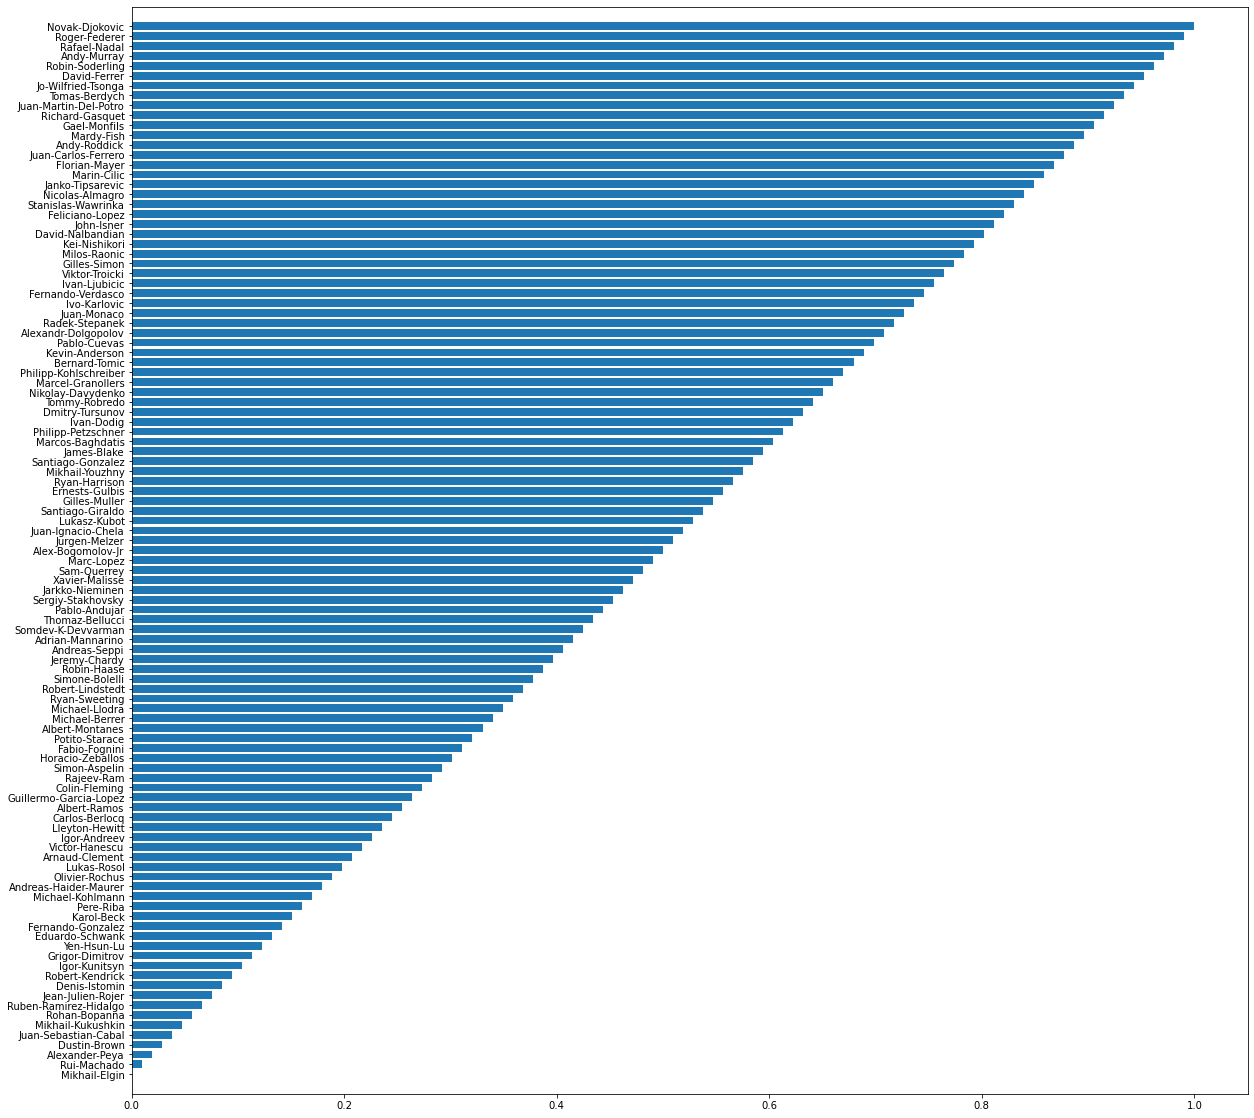

In [71]:
def Gibbs_against_table(skills):
    table = np.zeros((len(skills), len(skills)))
    for i in range(len(skills)):
        table[i, :] = np.vectorize(lambda x: scipy.stats.norm.cdf(skills[i] - skills[x]).mean())(np.arange(len(skills)))
        table[i, i] = 0
    return table

Gibbs_table = Gibbs_against_table(skill_samples)
# sorted_barplot(np.mean(Gibbs_table, axis=1), W)
sorted_barplot(np.sum(Gibbs_table > 0.5, axis=1) / 106, W)
plt.savefig('plots/e2.jpg')

### 3. EP

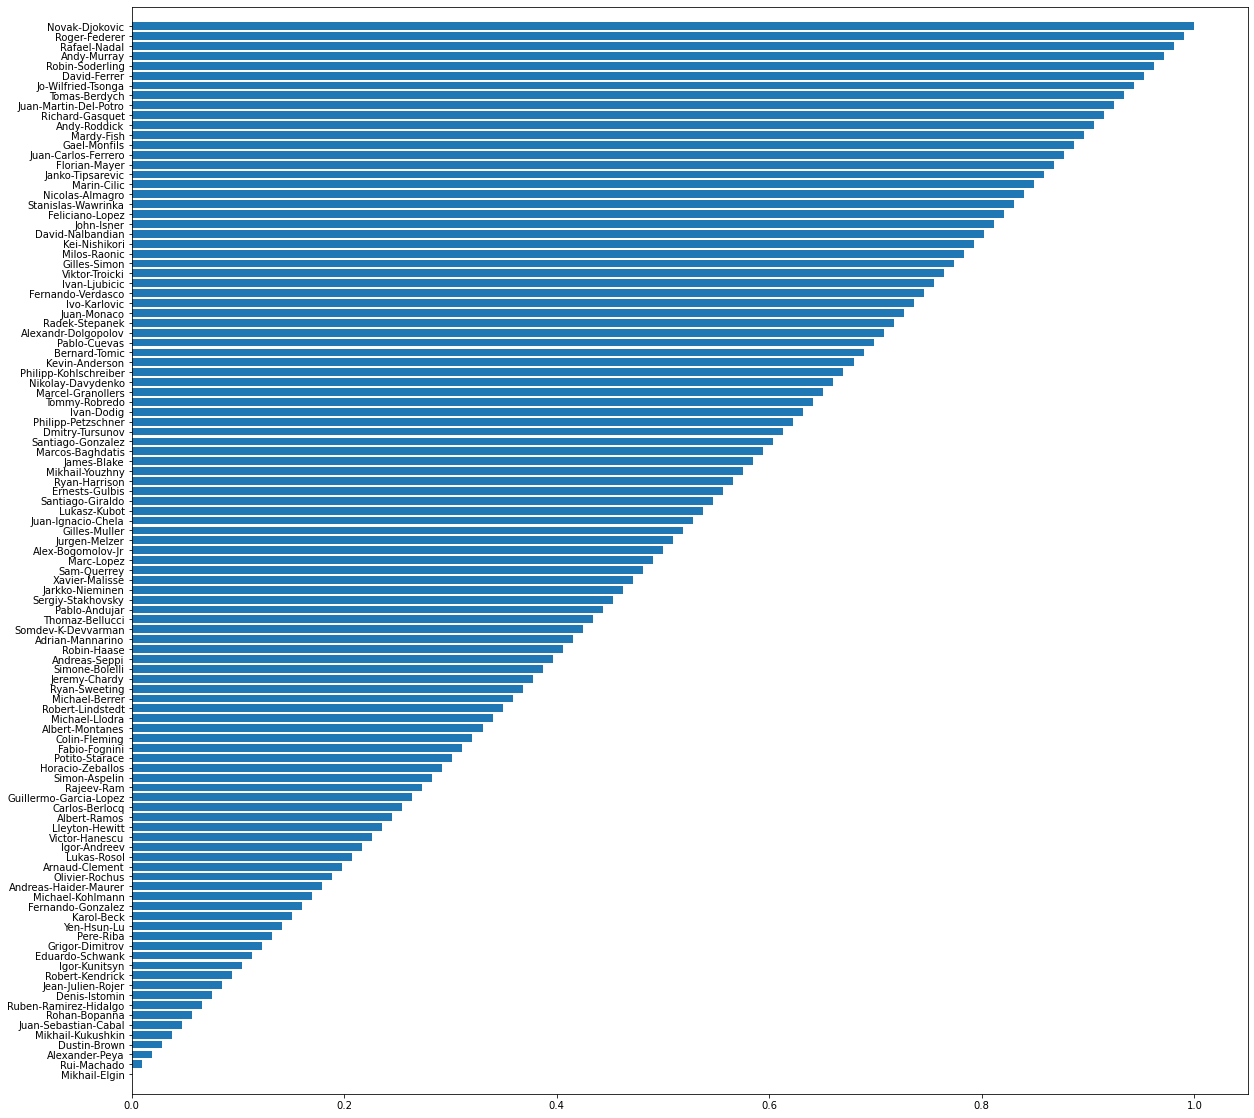

In [72]:
def EP_against_table(mean_player_skills, precision_player_skills):
    table = np.zeros((len(mean_player_skills), len(mean_player_skills)))
    for i in range(len(mean_player_skills)):
        table[i, :] = np.vectorize(lambda x: prob_winning(mean_player_skills[i], mean_player_skills[x]
                                                          , precision_player_skills[i], 
                                                          precision_player_skills[x]))(np.arange(len(mean_player_skills)))
        table[i, i] = 0
    return table

EP_table = EP_against_table(mean_player_skills, precision_player_skills)
# sorted_barplot(np.mean(EP_table, axis=1), W)
sorted_barplot(np.sum(EP_table > 0.5, axis=1) / 106, W)
plt.savefig('plots/e3.jpg')

In [55]:
np.sum(np.abs(np.sum(Gibbs_table, axis=1) / 106 - np.sum(EP_table, axis=1) / 106))

0.22699714466432416

In [37]:
import gibbs2
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.linalg

num_iters = 1100

iS = np.zeros((M, M))  # Container for sum of precision matrices (likelihood terms)        
for g in range(N):
    iS[np.ix_(G[g], G[g])] += np.array([[1, -1], [-1, 1]])
    # TODO: Build the iS matrix
# Posterior precision matrix
pv = 0.5 * np.ones(M)
iSS = iS + np.diag(1. / pv)
# Use Cholesky decomposition to sample from a multivariate Gaussian
iR = scipy.linalg.cho_factor(iSS)  # Cholesky decomposition of the posterior precision matrix

samples = []
for _ in range(3):
    samples.append(gibbs2.gibbs_sample(G, M, num_iters, np.random.randn(M, 1), iR))

100%|███████████████████████████████████████| 1100/1100 [00:11<00:00, 99.36it/s]


In [38]:
s = gibbs2.gibbs_sample(G, M, 100, np.zeros((M, 1)), iR)
ss = np.zeros((M, 100))
for k in range(100):
    ss[:, k] = gibbs2.gibbs_sample(G, M, 10, s[:, -1], iR)[:, -1]

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 111.77it/s]


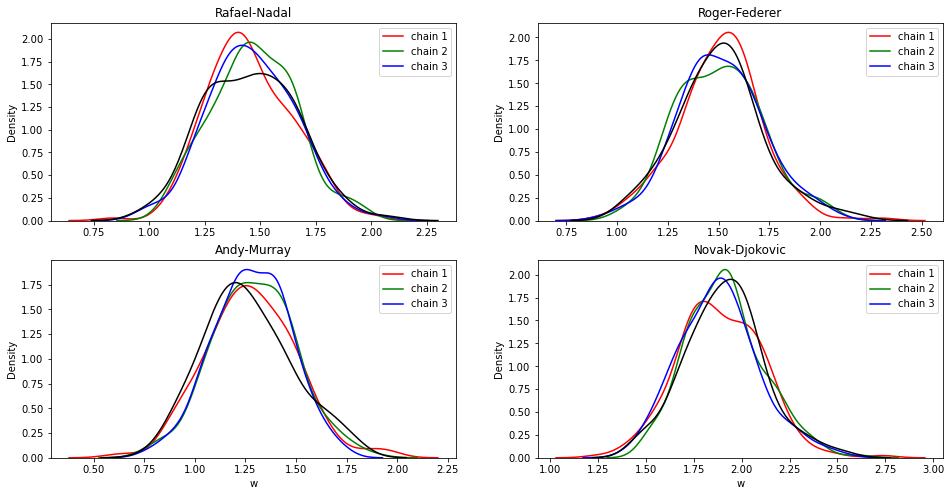

In [16]:
from scipy.stats.kde import gaussian_kde
burning_time = 10
tau = 10
P = [0, 4, 10, 15]
plt.figure(figsize=(16, 8))
c = ['r', 'g', 'b']

for i, p in enumerate(P):
    ax = plt.subplot(2, 2, i + 1)
#     sns.set(style="whitegrid")
    for j in range(3):
        s = samples[j]
#         sns.histplot(s[p, burning_time::tau], kde=True, color="skyblue", stat="density", bins=30)
#         kde = gaussian_kde(s[p, burning_time::tau])
#         dist_space = np.linspace(np.min(s), np.max(s), 100)
#         plt.plot(dist_space, kde(dist_space))
        sns.kdeplot(s[p, burning_time::tau], ax=ax, color=c[j])
#     if i % 2 == 0:
#         plt.ylabel('prob')
    sns.kdeplot(ss[p, :], ax=ax, color='black')
    if i >= 2:
        plt.xlabel('w')
    plt.legend(['chain '+ str(j + 1) for j in range(3)])
    plt.title(W[p][0])
# plt.savefig('plots/a4.jpg')

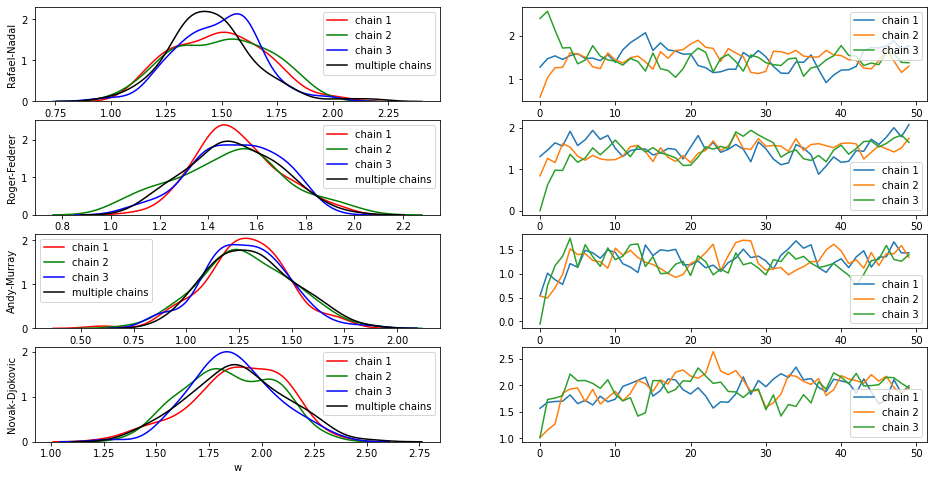

In [40]:
from scipy.stats.kde import gaussian_kde
burning_time = 100
tau = 10
P = [0, 4, 10, 15]
plt.figure(figsize=(16, 8))
c = ['r', 'g', 'b']

for i, p in enumerate(P):
    ax = plt.subplot(4, 2, i * 2 + 1)
    for j in range(3):
        s = samples[j]
        sns.kdeplot(s[p, burning_time::tau], ax=ax, color=c[j])
    sns.kdeplot(ss[p, :], ax=ax, color='black')
    if i == 3:
        plt.xlabel('w')
    a = ['chain '+ str(j + 1) for j in range(3)]
    a.append('multiple chains')
    plt.legend(a)
    plt.ylabel(W[p][0])
    plt.subplot(4, 2, i * 2 + 2)
    for j in range(3):
        plt.plot(samples[j][p, :50])
        plt.xticks(np.arange(0, 51, 10))
        plt.legend(['chain '+ str(j + 1) for j in range(3)])
plt.savefig('plots/a4.jpg')

<Figure size 432x288 with 0 Axes>

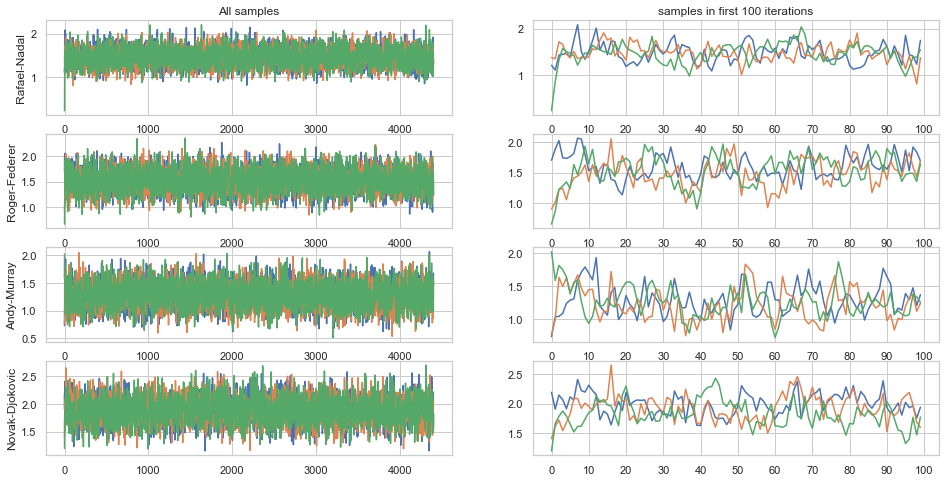

## Office Hour 1
1. The joint distribution method is different from the marginal one, as the correlation is embedded in the joint distribution. The correlation tells us relation of 2 players, not simply just the mean and var.

2. The game output of two players would make one of their skill up(winner) and the other(loser), making them negatively correlated.

3. Q: Would the message passing be overfit?
    A: In practice, it seems wouldn't be. Because we're not guessing a parameter, but assigning preference to each sample selection instead.
    
4. Damb update: If EP fails to converge, averaging the new value and the old ones to force there's just a little bit move.

5. If we do empirical average, weak player would have less games, resulting to unbalanced data.

6. For Qe(2), e.g. given samples of two players, estimate their rank: estimate P(w1>w2) <=> count(w1>w2) => for more players: First estimate the prob of player i is the top1, then fix i and select the second player...

## Question:
1. ChatGPT said: if the autocorrelation drops rapidly as lag increases, then it indicates that the Markov chain is mixing well? Is it true? Why?
2. In EP, seems like, given game outputs y, w_1 and w_2 are not independent? A: Yes, and we could adjust the model to approximate the joint distribution p(w_1, w_2|y), but it's not necessary in the course.

# TODO:
1. In question c, assume w_i and w_j are independent, given game output y_{ij}.
2. In question a&b, give trace plots with different initialization of w


# Office Hour 2:
1. I specify 10, but i can choose 100 as the burning time to as a safety choice!!!
2. Why we assume the variance of game outcome is 1? Because if the skills are noisy with a std, say 2, then the skills becomes 2 * w_i, with a std 2, which still returns w_i in the formula of Prob(winning). Thus, the variance 1 here is not important.
3. 

# TODO:
1. In question d(1), we assume the marginals are independent as in EP!
2. Interpret interesting behaviours in Qe. (1). Do the first few ranks by empirical and EP/Gibbs match?; (2) Do the last few ranks different?(Yes, it is.) Then give some interesting insights.
3. Convergene/burning check: Run GS for burning time, get a sample $w^{(b)}$ at time b; then choose it as a starting point, continue multiple chains(say 100) for 10 times, we get samples $w_1,...,w_{100}$, their distribution should be the correct joint distribution.
4. First run say, 1100 iterations, compute the posterior variance, and then re-adjust the number of iterations to match your desired std of mean(w_i)